In [214]:
import numpy as np
import matplotlib.pyplot as plt

In [215]:
def relu(x):
    return np.maximum(0, x)


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)


def relu_backward(grad_output, input):
    return grad_output * (input > 0)


def rot180(kernel):
    return np.rot90(kernel, 2, axes=(2, 3))


def cross_entropy_loss(y, t):
    # 批量平均损失
    return -np.sum(t * np.log(y + 1e-7)) / y.shape[0]


def softmax_backward(y, t):
    return (y - t) / y.shape[0]

In [ ]:
# conv2d
def conv2d(input, kernel, *, padding=0, stride=1):
    batch_size, num_channels, in_height, in_width = input.shape
    out_channels, _, kernel_height, kernel_width = kernel.shape

    out_height = int((in_height - kernel_height + 2 * padding) / stride) + 1
    out_width = int((in_width - kernel_width + 2 * padding) / stride) + 1

    output = np.zeros((batch_size, out_channels, out_height, out_width))

    padded_input = np.pad(input, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant')

    for b in range(batch_size):
        for c in range(out_channels):
            for h_out in range(out_height):
                for w_out in range(out_width):
                    h_start = h_out * stride
                    h_end = h_start + kernel_height
                    w_start = w_out * stride
                    w_end = w_start + kernel_width

                    receptive_field = padded_input[b, :, h_start:h_end, w_start:w_end]
                    output[b, c, h_out, w_out] = np.sum(receptive_field * kernel[c])

    return output

In [ ]:
# full convolution
def full_conv(input, kernel):
    batch_size, num_channels, in_height, in_width = input.shape
    out_channels, _, kernel_height, kernel_width = kernel.shape

    out_height = in_height + kernel_height - 1
    out_width = in_width + kernel_width - 1

    output = np.zeros((batch_size, out_channels, out_height, out_width))

    for b in range(batch_size):
        for c in range(out_channels):
            for h_out in range(out_height):
                for w_out in range(out_width):
                    # h_start: (in_height - 1) -> (in_height - out_height)
                    h_start = in_height - h_out - 1
                    h_end = h_start + kernel_height
                    # w_start: (in_width - 1) -> (in_width - out_width)
                    w_start = in_width - w_out - 1
                    w_end = w_start + kernel_width

                    top_padding = None
                    down_padding = None
                    left_padding = None
                    right_padding = None

                    if h_start < 0:
                        top_padding = -h_start
                        h_start = 0
                    if h_end > in_height:
                        down_padding = h_end - in_height
                        h_end = in_height
                    if w_start < 0:
                        left_padding = -w_start
                        w_start = 0
                    if w_end > in_width:
                        right_padding = w_end - in_width
                        w_end = in_width

                    receptive_field = input[b, :, h_start:h_end, w_start:w_end]
                    # pad receptive field to kernel size: [1, IC, KS, KS]
                    if top_padding is not None:
                        receptive_field = np.pad(receptive_field, ((0, 0), (top_padding, 0), (0, 0)), 'constant')
                    if down_padding is not None:
                        receptive_field = np.pad(receptive_field, ((0, 0), (0, down_padding), (0, 0)), 'constant')
                    if left_padding is not None:
                        receptive_field = np.pad(receptive_field, ((0, 0), (0, 0), (left_padding, 0)), 'constant')
                    if right_padding is not None:
                        receptive_field = np.pad(receptive_field, ((0, 0), (0, 0), (0, right_padding)), 'constant')

                    output[b, c, h_out, w_out] = np.sum(receptive_field * kernel[c])

    return output

In [220]:
# lenet-5: convolutionLayer
class ConvLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # He initialization
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(
            2.0 / (in_channels * kernel_size * kernel_size))
        self.bias = np.zeros((out_channels, 1))

        self.input = None
        self.grad_weights = None
        self.grad_bias = None
        self.conv_output = None

    def forward(self, input):
        self.input = input
        self.conv_output = conv2d(input, self.weights, stride=self.stride, padding=self.padding)
        # conv_output: (B, OC, OH, OW)
        # bias: (OC, 1) -> (1, OC, 1, 1)
        output = relu(self.conv_output + self.bias.reshape(1, -1, 1, 1))
        return output

    def backward(self, grad_output):
        # batch_size, num_channels, in_height, in_width = grad_output.shape

        grad_output = relu_backward(grad_output, self.conv_output)

        # rotated_kernel: [OC, IC, KS, KS] -> [IC, OC, KS, KS]
        # grad_output: [B, OC, OH, OW]
        # grad_input: [IC, B, H, W] -> [B, IC, H, W]
        rotated_kernel = rot180(self.weights)
        rotated_kernel = np.transpose(rotated_kernel, (1, 0, 2, 3))
        grad_input = full_conv(rotated_kernel, grad_output)
        grad_input = np.transpose(grad_input, (1, 0, 2, 3))

        # input: [B, IC, H, W] -> [IC, B, H, W]
        # grad_output: [B, OC, OH, OW] -> [OC, B, OH, OW]
        # grad_weights: [IC, OC, KS, KS] -> [OC, IC, KS, KS]
        self.grad_weights = conv2d(np.transpose(self.input, (1, 0, 2, 3)), np.transpose(grad_output, (1, 0, 2, 3)),
                                   padding=self.padding)
        self.grad_weights = np.transpose(self.grad_weights, (1, 0, 2, 3))

        # grad_output: [B, OC, OH, OW] -> [OC, 1]
        self.grad_bias = np.sum(grad_output, axis=(0, 2, 3)).reshape(self.out_channels, 1)
        return grad_input


In [ ]:
class AvgPool:
    def __init__(self, kernel_size, stride=1):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, num_channels, in_height, in_width = x.shape
        out_height = int((in_height - self.kernel_size) / self.stride) + 1
        out_width = int((in_width - self.kernel_size) / self.stride) + 1

        output = np.zeros((batch_size, num_channels, out_height, out_width))

        for b in range(batch_size):
            for c in range(num_channels):
                for h_out in range(out_height):
                    for w_out in range(out_width):
                        h_start = h_out * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w_out * self.stride
                        w_end = w_start + self.kernel_size

                        receptive_field = x[b, c, h_start:h_end, w_start:w_end]
                        output[b, c, h_out, w_out] = np.mean(receptive_field)

        return output

    # average pooling layer backward
    def backward(self, grad_output):
        batch_size, num_channels, out_height, out_width = grad_output.shape
        in_height = int((out_height - 1) * self.stride + self.kernel_size)
        in_width = int((out_width - 1) * self.stride + self.kernel_size)

        grad_input = np.zeros((batch_size, num_channels, in_height, in_width))

        for b in range(batch_size):
            for c in range(num_channels):
                for h_out in range(out_height):
                    for w_out in range(out_width):
                        h_start = h_out * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w_out * self.stride
                        w_end = w_start + self.kernel_size

                        grad_input[b, c, h_start:h_end, w_start:w_end] = grad_output[b, c, h_out, w_out] / (
                                self.kernel_size * self.kernel_size)

        return grad_input

In [ ]:
class Flatten:
    def __init__(self):
        self.input = None

    def forward(self, x):
        self.input = x
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.input.shape)

In [ ]:
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features

        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2.0 / (in_features + out_features))
        self.bias = np.zeros((1, out_features))

        self.input = None
        self.grad_weights = None
        self.grad_bias = None
        self.output = None

    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.weights) + self.bias
        return self.output

    def backward(self, grad_output):
        # grad_weights = input.T * grad_output
        # input: [B, I] -> [I, B]
        # grad_output: [B, O]
        self.grad_weights = np.dot(self.input.T, grad_output)

        # grad_bias
        self.grad_bias = np.sum(grad_output, axis=0, keepdims=True)

        # grad_input = grad_output * weights.T
        # grad_output: [B, O]
        # weights: [I, O] -> [O, I]
        # grad_input: [B, I]
        return np.dot(grad_output, self.weights.T)

In [225]:
class LeNet:
    def __init__(self):
        self.conv1 = ConvLayer(in_channels=1, out_channels=6, kernel_size=5)
        self.avgpool1 = AvgPool(kernel_size=2, stride=2)
        self.conv2 = ConvLayer(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = AvgPool(kernel_size=2, stride=2)
        self.flatten = Flatten()
        self.linear1 = Linear(16 * 5 * 5, 120)
        self.linear2 = Linear(120, 84)
        self.linear3 = Linear(84, 10)

        self.loss = []

    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.avgpool1.forward(x)
        x = self.conv2.forward(x)
        x = self.avgpool2.forward(x)
        x = self.flatten.forward(x)
        x = self.linear1.forward(x)
        x = relu(x)
        x = self.linear2.forward(x)
        x = relu(x)
        x = self.linear3.forward(x)
        x = softmax(x)
        return x

    def backward(self, grad_output):
        # softmax的反向传播直接通过y-t传入即可，必须使用交叉熵损失函数
        grad_output = self.linear3.backward(grad_output)
        grad_output = relu_backward(grad_output, self.linear2.output)
        grad_output = self.linear2.backward(grad_output)
        grad_output = relu_backward(grad_output, self.linear1.output)
        grad_output = self.linear1.backward(grad_output)
        grad_output = self.flatten.backward(grad_output)
        grad_output = self.avgpool2.backward(grad_output)
        grad_output = self.conv2.backward(grad_output)
        grad_output = self.avgpool1.backward(grad_output)
        grad_output = self.conv1.backward(grad_output)
        return grad_output

In [ ]:
def load_mnist():
    # 加载训练数据
    with open('../MNIST/train-images.idx3-ubyte', 'rb') as f:
        train_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape((-1, 1, 28, 28))

    with open('../MNIST/train-labels.idx1-ubyte', 'rb') as f:
        train_labels = np.frombuffer(f.read(), np.uint8, offset=8)

    # 加载测试数据
    with open('../MNIST/t10k-images.idx3-ubyte', 'rb') as f:
        test_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape((-1, 1, 28, 28))

    with open('../MNIST/t10k-labels.idx1-ubyte', 'rb') as f:
        test_labels = np.frombuffer(f.read(), np.uint8, offset=8)

    # 添加填充
    train_images = np.pad(train_images, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
    test_images = np.pad(test_images, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')

    # labels转换为one-hot
    train_labels = np.eye(10)[train_labels]
    test_labels = np.eye(10)[test_labels]

    return (train_images, train_labels), (test_images, test_labels)

In [229]:
def train(model, train_images, train_labels, epochs, learning_rate, batch_size):
    for epoch in range(epochs):
        correct = 0
        loss_list = []
        batch_num = 0
        for i in range(0, len(train_images), batch_size):
            batch_num += 1
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]

            # forward
            output = model.forward(batch_images)
            loss = cross_entropy_loss(output, batch_labels)
            loss_list.append(loss)

            # backward
            grad_output = softmax_backward(output, batch_labels)
            model.backward(grad_output)

            # update
            for layer in [model.conv1, model.conv2, model.linear1, model.linear2, model.linear3]:
                layer.weights -= learning_rate * layer.grad_weights
                layer.bias -= learning_rate * layer.grad_bias

            # calculate accuracy
            pred = np.argmax(output, axis=1)
            correct += np.sum(pred == np.argmax(batch_labels, axis=1))
            print(f'iter {i / batch_size}, loss: {loss}')
        model.loss.append(loss_list)
        avg_loss = np.mean(np.array(loss_list))
        print('Epoch %d/%d, avg_loss: %.3f, train accuracy: %.3f' % (
            epoch + 1, epochs, avg_loss, correct / len(train_images)))


In [237]:
def test(model, test_images, test_labels):
    correct = 0
    for image, label in zip(test_images, test_labels):
        image = image.reshape(1, 1, 32, 32)
        output = model.forward(image)
        if np.argmax(output) == np.argmax(label):
            correct += 1
    print('Test accuracy: %.3f' % (correct / len(test_images)))

In [ ]:
# hyperparameters setting
batch_size = 128
learning_rate = 0.01

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_mnist()
lenet = LeNet()

In [240]:
epochs = 1

train(lenet, train_images, train_labels, epochs, learning_rate, batch_size)

iter 0.0, loss: 0.4331775719205947
iter 1.0, loss: 0.4060616779460332
iter 2.0, loss: 0.2875459723909737
iter 3.0, loss: 0.5833389545277302
iter 4.0, loss: 0.5104735039712496
iter 5.0, loss: 0.43607517528313033
iter 6.0, loss: 0.4349294694936735
iter 7.0, loss: 0.5282820910302832
iter 8.0, loss: 0.530271067037601
iter 9.0, loss: 0.5797006971435016
iter 10.0, loss: 0.755507411387034
iter 11.0, loss: 0.4716191844677401
iter 12.0, loss: 0.3728579239708518
iter 13.0, loss: 0.3086162718226981
iter 14.0, loss: 0.34347530086654177
iter 15.0, loss: 0.4542289694548197
iter 16.0, loss: 0.4086091830370062
iter 17.0, loss: 0.30770063198015324
iter 18.0, loss: 0.3862943379950754
iter 19.0, loss: 0.4024421713213987
iter 20.0, loss: 0.378873645412522
iter 21.0, loss: 0.42120778816678983
iter 22.0, loss: 0.46074579962049067
iter 23.0, loss: 0.47898448240489316
iter 24.0, loss: 0.32846235722088934
iter 25.0, loss: 0.46324396936396395
iter 26.0, loss: 0.4449147630852868
iter 27.0, loss: 0.50021762042491

KeyboardInterrupt: 

In [245]:
# 保存模型
import pickle
with open('lenet.pkl', 'wb') as f:
    pickle.dump(lenet, f)

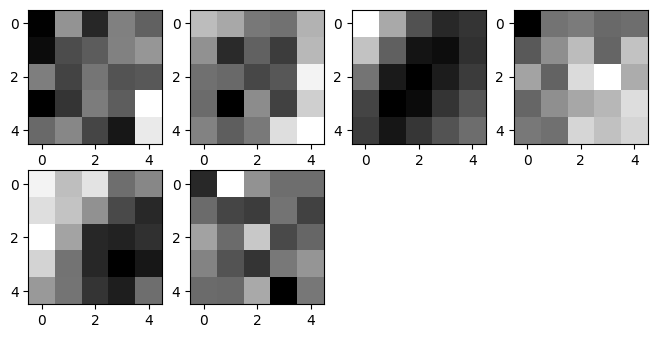

In [241]:
# 将lenet的卷积核可视化
def visualize_kernels(model):
    kernels = model.conv1.weights
    fig = plt.figure(figsize=(8, 8))
    for i in range(kernels.shape[0]):
        ax = fig.add_subplot(4, 4, i + 1)
        ax.imshow(kernels[i][0], cmap='gray')
    plt.show()

visualize_kernels(lenet)

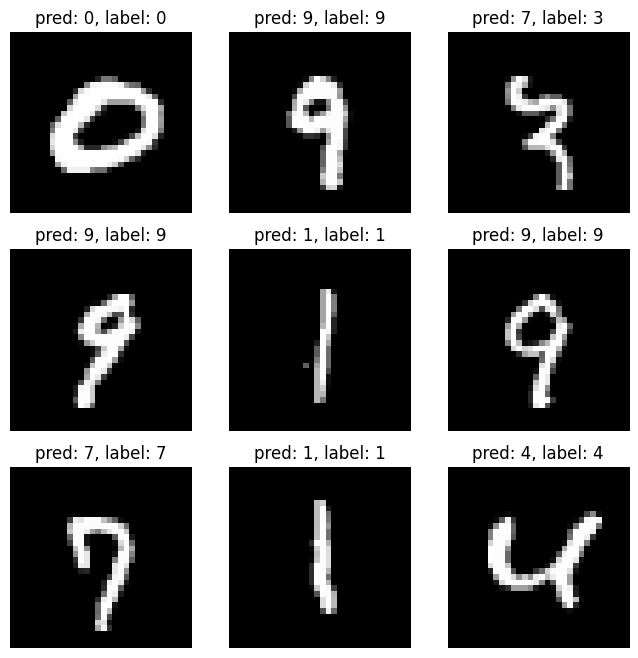

In [244]:
# 随机从测试集中选择9张图片测试，以九宫格形式打印输出
def visualize_results(model, test_images, test_labels):
    fig = plt.figure(figsize=(8, 8))
    for i in range(9):
        index = np.random.randint(0, len(test_images))
        image = test_images[index]
        label = test_labels[index]
        image = image.reshape(1, 1, 32, 32)
        output = model.forward(image)
        pred = np.argmax(output)
        ax = fig.add_subplot(3, 3, i + 1)
        plt.axis('off')
        ax.imshow(image[0][0], cmap='gray')
        ax.set_title(f'pred: {pred}, label: {np.argmax(label)}')
    plt.show()

visualize_results(lenet, test_images, test_labels)

In [238]:
# test model
test(lenet, test_images, test_labels)

Test accuracy: 0.819
